In [2]:
conda install --force-reinstall numpy opencv

Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\s221430749\AppData\Local\anaconda3

  added / updated specs:
    - numpy
    - opencv


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    double-conversion-3.3.1    |       he0c23c2_0          70 KB  conda-forge
    hdf5-1.14.4                |nompi_hd5d9e70_105         2.0 MB  conda-forge
    libopencv-4.10.0           |qt6_py310hc3e0e48_615        31.6 MB  conda-forge
    opencv-4.10.0              |qt6_py310h7ab019a_615          26 KB  conda-forge
    py-opencv-4.10.0           |qt6_py310ha698f67_615         1.1 MB  conda-forge
    qt6-main-6.8.1             |       h1259614_2        87.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:       122.5 MB

The foll

In [5]:
pip install numpy opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define dataset paths
dataset_root = "C:\\Users\\s221430749\\Downloads\\VRBiom\\VRBiom\\data"  # Root directory containing subfolders with .avi files
output_path = "C:\\Users\\s221430749\\Downloads\\VRBiom"  # Where extracted frames will be stored

# Create output folders
os.makedirs(output_path, exist_ok=True)

# Step 1: Recursively find all .avi files in subdirectories
video_files = []
for root, _, files in os.walk(dataset_root):
    for file in files:
        if file.endswith(".avi"):
            video_files.append(os.path.join(root, file))

# Step 2: Extract unique identities (Assume identity is in folder name or filename)
identities = list(set([os.path.basename(os.path.dirname(v)) for v in video_files]))  # Parent folder as identity

# Step 3: Split identities into train (33%), val (33%), test (33%) ensuring disjoint sets
train_ids, temp_ids = train_test_split(identities, test_size=0.5, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# Step 4: Process videos and extract frames
for video_path in video_files:
    identity = os.path.basename(os.path.dirname(video_path))  # Identity from parent folder
    partition = "train" if identity in train_ids else "val" if identity in val_ids else "test"

    # Open video file
    cap = cv2.VideoCapture(video_path)
    
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Save every 10th frame
        if frame_idx % 10 == 0:
            save_folder = os.path.join(output_path, partition, identity)
            os.makedirs(save_folder, exist_ok=True)
            frame_filename = os.path.join(save_folder, f"{os.path.basename(video_path)}_frame{frame_idx}.jpg")
            cv2.imwrite(frame_filename, frame)

        frame_idx += 1
    
    cap.release()

print("Dataset processing complete! Frames are stored in:")
print(f"{output_path}/train, {output_path}/val, {output_path}/test")



Dataset processing complete! Frames are stored in:
C:\Users\s221430749\Downloads\VRBiom/train, C:\Users\s221430749\Downloads\VRBiom/val, C:\Users\s221430749\Downloads\VRBiom/test


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 定义图像尺寸和批次大小
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 数据增强
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# 加载数据
train_generator = train_datagen.flow_from_directory(
    "C:\\Users\\s221430749\\Downloads\\VRBiom\\train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)
import numpy as np
import os

# Function to extract class name from filename
def get_class_from_filename(filename):
    # Check if 'BF' is present in the filename
    if 'BF' in filename:
        return 'BF'
    return 'Other'  # For any filenames that don't contain 'BF'

# Apply function to each filename
class_labels = [get_class_from_filename(f) for f in train_generator.filenames]

# Convert labels to binary: 1 if 'BF' is found, otherwise 0
train_labels = np.array([1 if label == 'BF' else 0 for label in class_labels])

# Update the labels in the generator
train_generator.classes = train_labels


val_generator = val_test_datagen.flow_from_directory(
    "C:\\Users\\s221430749\\Downloads\\VRBiom\\val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)


test_generator = val_test_datagen.flow_from_directory(
    "C:\\Users\\s221430749\\Downloads\\VRBiom\\test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)
# Apply function to each filename
class_labels_val = [get_class_from_filename(f) for f in val_generator.filenames]

# Convert labels to binary: 1 if 'BF' is found, otherwise 0
val_labels = np.array([1 if label == 'BF' else 0 for label in class_labels_val])

# Update the labels in the generator
val_generator.classes = val_labels

# Apply function to each filename
class_labels_test = [get_class_from_filename(f) for f in test_generator.filenames]

# Convert labels to binary: 1 if 'BF' is found, otherwise 0
test_labels = np.array([1 if label == 'BF' else 0 for label in class_labels_test])

# Update the labels in the generator
test_generator.classes = test_labels


Found 66574 images belonging to 58 classes.
Found 36878 images belonging to 29 classes.
Found 39500 images belonging to 30 classes.


In [2]:
print("Unique train labels:", np.unique(train_labels))
print("Unique val labels:", np.unique(val_labels))
print("Unique test labels:", np.unique(test_labels))

Unique train labels: [0 1]
Unique val labels: [0 1]
Unique test labels: [0 1]


In [13]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# 加载预训练模型（不包含分类头）
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# 冻结大部分层（只训练最后几层）
for layer in base_model.layers[:-10]:
    layer.trainable = False

# 构建分类头
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)  # 二分类问题

# 组合模型
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 15,071,873 (57.49 MB)

 Trainable params: 12,616,321 (48.13 MB)

 Non-trainable params: 2,455,552 (9.37 MB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 回调函数：提前停止 & 动态调整学习率
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

# 训练模型
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 3397s 2s/step - accuracy: 0.7335 - loss: 0.7111 - val_accuracy: 0.5859 - val_loss: 11.9611 - learning_rate: 0.0010
Epoch 2/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 3020s 1s/step - accuracy: 0.9181 - loss: 0.2089 - val_accuracy: 0.5182 - val_loss: 40.2437 - learning_rate: 0.0010
Epoch 3/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 3046s 1s/step - accuracy: 0.9456 - loss: 0.1450 - val_accuracy: 0.5796 - val_loss: 14.7444 - learning_rate: 0.0010
Epoch 4/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 3080s 1s/step - accuracy: 0.9601 - loss: 0.1099 - val_accuracy: 0.5124 - val_loss: 88.1159 - learning_rate: 0.0010
Epoch 5/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 3099s 1s/step - accuracy: 0.9789 - loss: 0.0645 - val_accuracy: 0.7549 - val_loss: 3.1056 - learning_rate: 5.0000e-04


1235/1235 ━━━━━━━━━━━━━━━━━━━━ 766s 616ms/step 
Optimal Threshold: 0.9977529048919678
EER: 8.31%


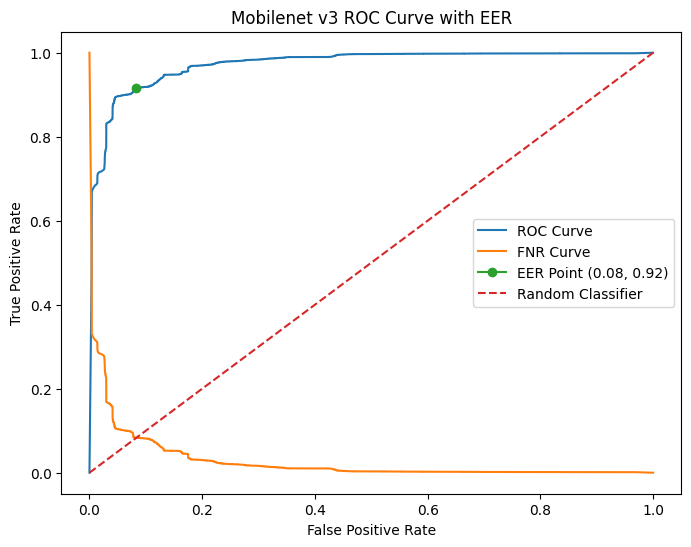

In [15]:
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Assume y_true and y_pred_prob are your true labels and predicted probabilities
y_true = test_generator.classes  # True labels
y_pred_prob = model.predict(test_generator)  # Predicted probabilities

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

# Calculate FNR (False Negative Rate)
fnr = 1 - tpr

# Find the optimal threshold where FPR equals FNR (EER)
eer_index = np.nanargmin(np.abs(fnr - fpr))
optimal_threshold = thresholds[eer_index]
eer = fpr[eer_index]

print(f"Optimal Threshold: {optimal_threshold}")
print(f"EER: {eer * 100:.2f}%")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot(fpr, fnr, label='FNR Curve')
plt.plot(fpr[eer_index], tpr[eer_index], marker='o', label=f'EER Point ({fpr[eer_index]:.2f}, {tpr[eer_index]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mobilenet v3 ROC Curve with EER')
plt.legend()
plt.show()


In [10]:
import pandas as pd

# 获取真实标签和预测概率
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)

# 根据 EER 阈值进行分类
y_pred_class = (y_pred_prob >= optimal_threshold).astype(int)
y_pred_class = y_pred_class.flatten()
# 找出错误分类的样本
misclassified_indices = np.where(y_pred_class.flatten() != y_true)[0]

# 统计 FP（假阳性） 和 FN（假阴性）
false_positives = misclassified_indices[y_pred_class[misclassified_indices] == 1]  # FP: 预测为正例但实际为负例
false_negatives = misclassified_indices[y_pred_class[misclassified_indices] == 0]  # FN: 预测为负例但实际为正例

# 获取对应的文件名
filenames = np.array(test_generator.filenames)

# 创建一个 DataFrame，方便分析
df_misclassified = pd.DataFrame({
    'Filename': filenames[misclassified_indices],
    'True Label': y_true[misclassified_indices],
    'Predicted Probability': y_pred_prob[misclassified_indices].flatten(),
    'Predicted Label': y_pred_class[misclassified_indices].flatten(),
    'Error Type': ['FP' if i in false_positives else 'FN' for i in misclassified_indices]
})

# 显示前 10 个错误分类的样本
num_misclassified = misclassified_indices.shape[0]
print("Number of misclassified samples:", num_misclassified)
print(df_misclassified.head(10))
print(df_misclassified.tail(10))

1235/1235 ━━━━━━━━━━━━━━━━━━━━ 649s 526ms/step
Number of misclassified samples: 5782
                                            Filename  True Label  \
0   003\BF_003_L00_003_00_1_9gymaegb.avi_frame10.jpg           1   
1  003\BF_003_L00_003_00_1_9gymaegb.avi_frame170.jpg           1   
2   003\BF_003_L00_003_00_1_9gymaegb.avi_frame20.jpg           1   
3  003\BF_003_L00_003_00_1_9gymaegb.avi_frame260.jpg           1   
4  003\BF_003_L00_003_00_1_9gymaegb.avi_frame650.jpg           1   
5   003\BF_003_L00_003_00_2_3pc21bhe.avi_frame30.jpg           1   
6  003\BF_003_L00_003_00_2_3pc21bhe.avi_frame670.jpg           1   
7  003\BF_003_L00_003_00_3_vm3t0qgw.avi_frame550.jpg           1   
8   003\BF_003_L01_003_00_1_k9kdpdbe.avi_frame10.jpg           1   
9   003\BF_003_L01_003_00_1_k9kdpdbe.avi_frame20.jpg           1   

   Predicted Probability  Predicted Label Error Type  
0           0.000000e+00                0         FN  
1           0.000000e+00                0         FN  
2

In [15]:
# 统计真实正例（攻击样本）和真实负例（合法用户）
total_attack_samples = np.sum(y_true == 0)  # 真实攻击样本数
total_bona_fide_samples = np.sum(y_true == 1)  # 真实合法用户数

# 计算 APCER 和 BPCER
APCER = false_positives.size / total_bona_fide_samples if total_bona_fide_samples > 0 else 0
BPCER = false_negatives.size / total_attack_samples if total_attack_samples > 0 else 0

print(f"APCER: {APCER:.3f}")
print(f"BPCER: {BPCER:.3f}")


APCER: 0.136
BPCER: 0.158


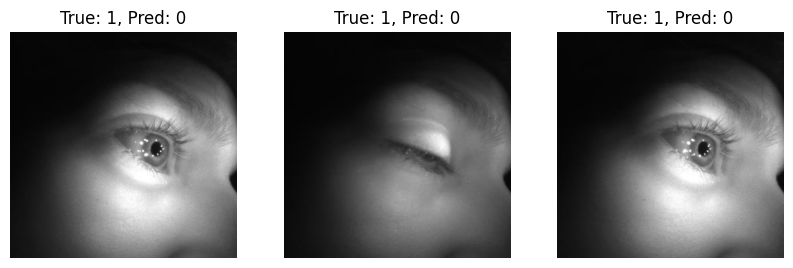

In [16]:
# 可视化部分误分类样本
plt.figure(figsize=(10,10))
for i, idx in enumerate(misclassified_indices[:3]):  # 显示前9个错误分类样本
    img_path = test_generator.filepaths[idx]  # 获取文件路径
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {y_true[idx]}, Pred: {y_pred_class[idx]}")

plt.show()

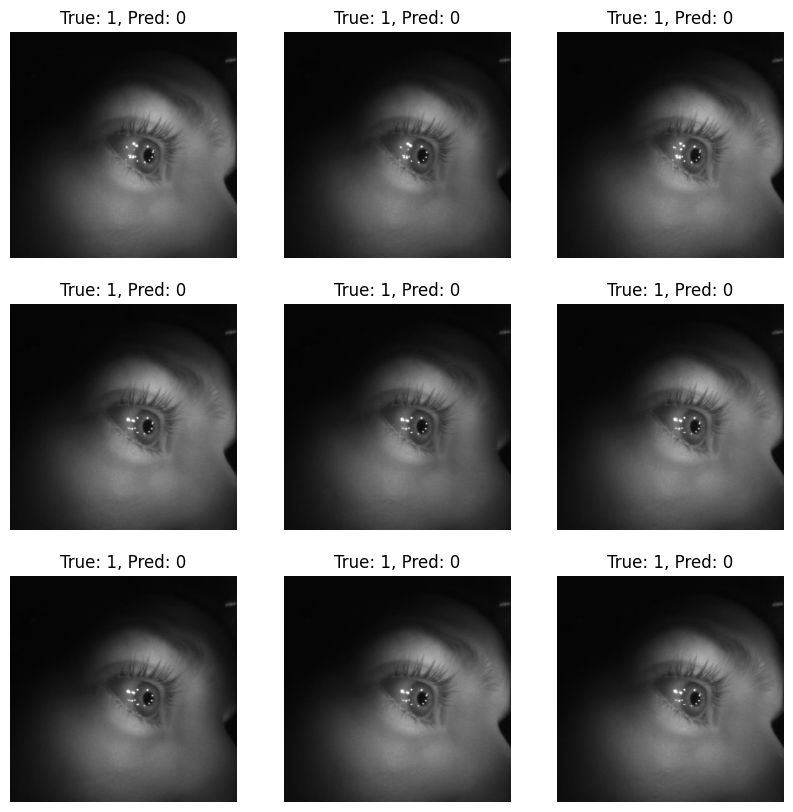

In [17]:
# 可视化部分误分类样本
plt.figure(figsize=(10,10))
for i, idx in enumerate(misclassified_indices[300:309]):  # 显示前9个错误分类样本
    img_path = test_generator.filepaths[idx]  # 获取文件路径
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {y_true[idx]}, Pred: {y_pred_class[idx]}")

plt.show()

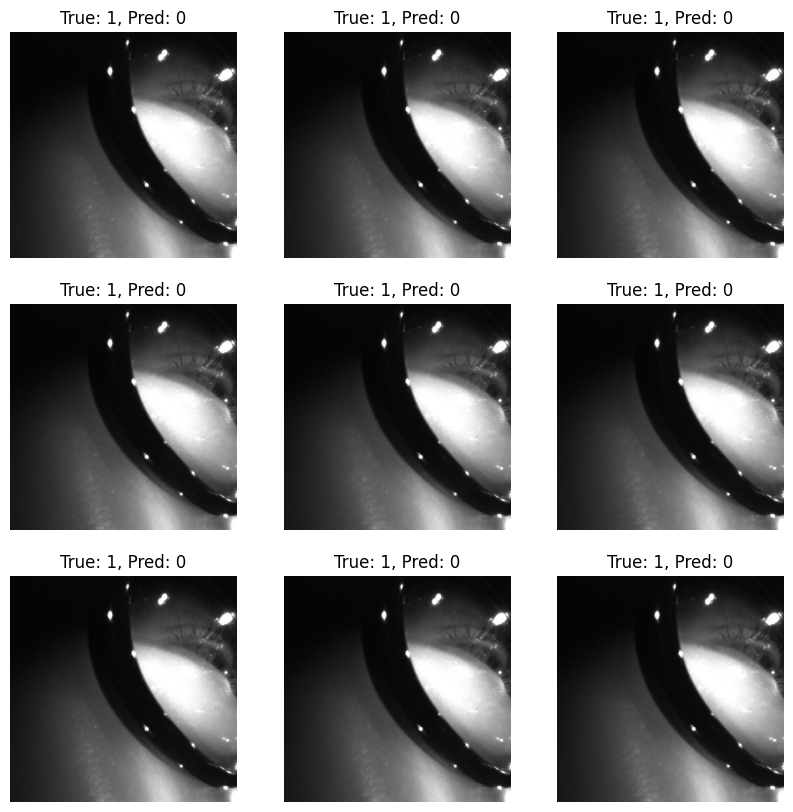

In [18]:
# 可视化部分误分类样本
plt.figure(figsize=(10,10))
for i, idx in enumerate(misclassified_indices[1000:1009]):  # 显示前9个错误分类样本
    img_path = test_generator.filepaths[idx]  # 获取文件路径
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {y_true[idx]}, Pred: {y_pred_class[idx]}")

plt.show()

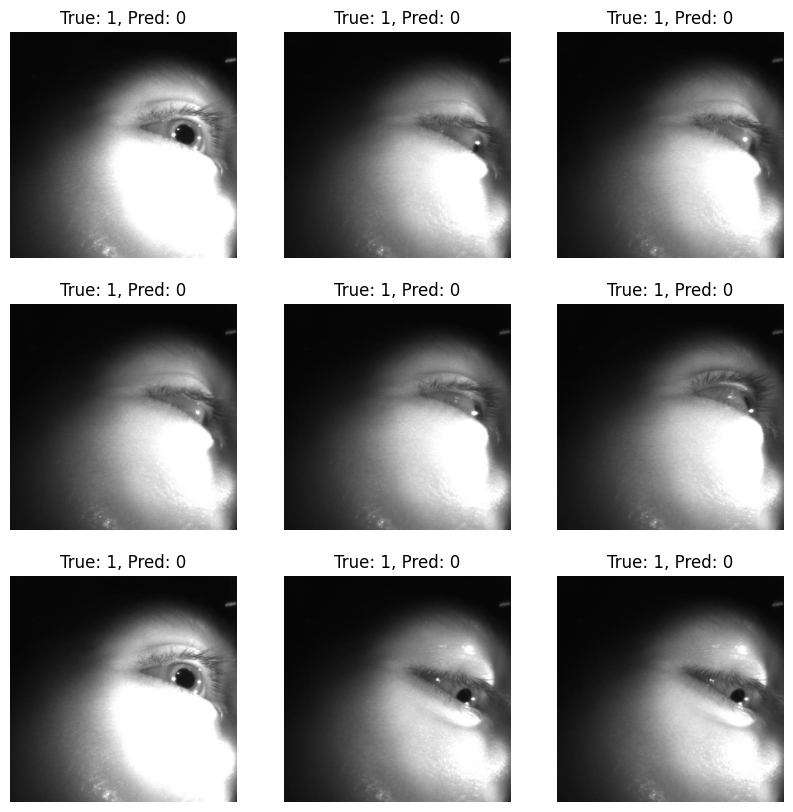

In [19]:
# 可视化部分误分类样本
plt.figure(figsize=(10,10))
for i, idx in enumerate(misclassified_indices[2000:2009]):  # 显示前9个错误分类样本
    img_path = test_generator.filepaths[idx]  # 获取文件路径
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {y_true[idx]}, Pred: {y_pred_class[idx]}")

plt.show()

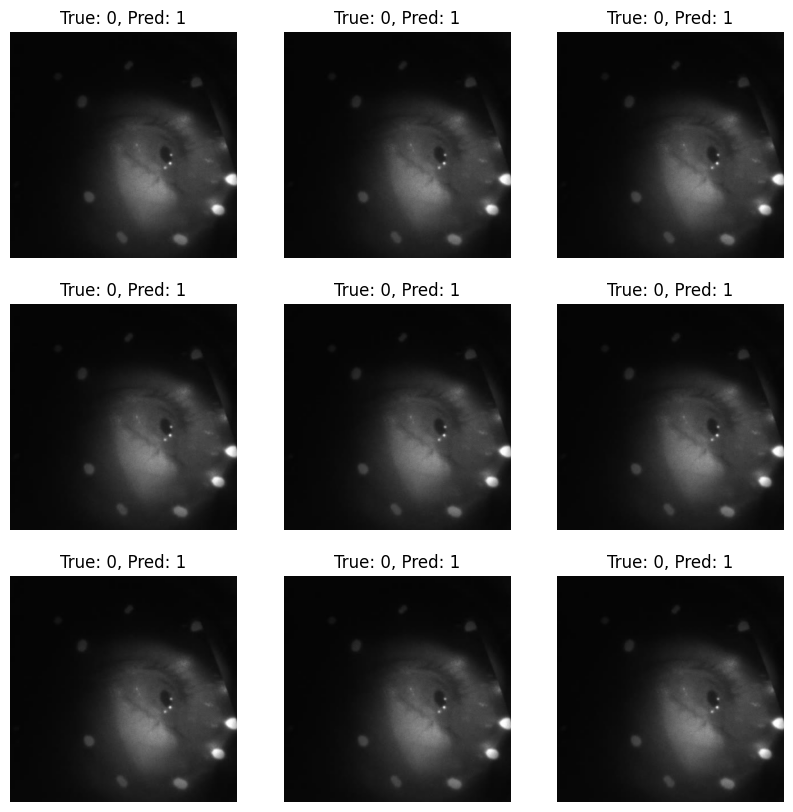

In [20]:
plt.figure(figsize=(10,10))
for i, idx in enumerate(misclassified_indices[5000:5009]):  # 显示前9个错误分类样本
    img_path = test_generator.filepaths[idx]  # 获取文件路径
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {y_true[idx]}, Pred: {y_pred_class[idx]}")

plt.show()

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from scipy import interpolate

# 设置GPU内存动态增长
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [22]:
base_model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3),
                                               alpha=1.0,
                                               depth_multiplier=1,
                                               dropout=0.001,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model_mobilenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # 输出一个概率值
])

model_mobilenet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


Epoch 1/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 2617s 1s/step - accuracy: 0.9766 - loss: 0.0587 - val_accuracy: 0.9187 - val_loss: 0.5448
Epoch 2/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 2455s 1s/step - accuracy: 0.9958 - loss: 0.0133 - val_accuracy: 0.9190 - val_loss: 0.6357
Epoch 3/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 2464s 1s/step - accuracy: 0.9959 - loss: 0.0168 - val_accuracy: 0.9183 - val_loss: 0.7301
Epoch 4/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 2468s 1s/step - accuracy: 0.9985 - loss: 0.0067 - val_accuracy: 0.9131 - val_loss: 1.0778
Epoch 5/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 2426s 1s/step - accuracy: 0.9984 - loss: 0.0081 - val_accuracy: 0.9432 - val_loss: 0.4883
Epoch 6/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 2489s 1s/step - accuracy: 0.9985 - loss: 0.0078 - val_accuracy: 0.9001 - val_loss: 1.4408
Epoch 7/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 2472s 1s/step - accuracy: 0.9984 - loss: 0.0093 - val_accuracy: 0.9325 - val_loss: 0.7532
Epoch 8/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 2503s 1s/step - accuracy: 0.9982 -

IndexError: index 3098 is out of bounds for axis 0 with size 847

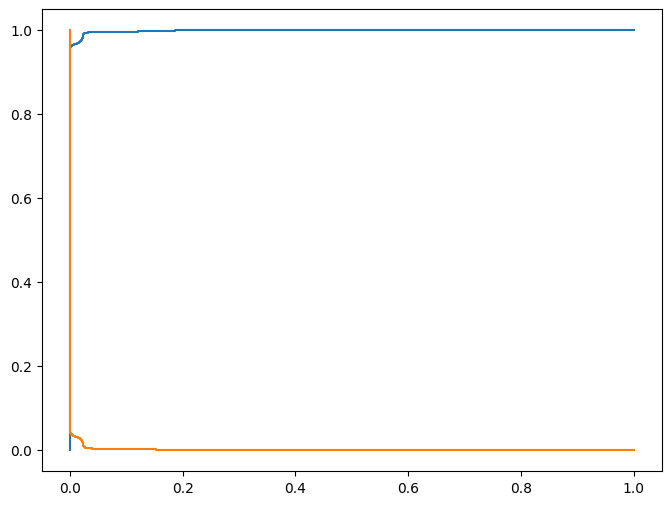

In [23]:
import time
# 训练模型
history = model_mobilenet.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# 测试模型

test_loss, test_acc = model_mobilenet.evaluate(test_generator)

print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

# 获取预测结果
y_true = test_generator.classes
start_time = time.time()  # 记录开始时间
y_pred_mobilenet = model_mobilenet.predict(test_generator)
end_time = time.time()  # 记录结束时间
elapsed_time = end_time - start_time  # 计算运行时间
print(f"模型运行时间: {elapsed_time:.4f} 秒")
y_pred_mobilenet = y_pred_mobilenet.ravel()

# 计算 ROC 和 AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_mobilenet)
roc_auc = auc(fpr, tpr)

# 计算 EER (Equal Error Rate)
fnr = 1 - tpr
eer_threshold = interpolate.interp1d(fpr, fnr)(0.05)  # 找到FPR和FNR相等的阈值
print(f'EER: {eer_threshold}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot(fpr, fnr, label='FNR Curve')
plt.plot(fpr[eer_index], tpr[eer_index], marker='o', label=f'EER Point ({fpr[eer_index]:.2f}, {tpr[eer_index]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with EER')
plt.legend()
plt.show()



In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d


In [25]:
# Load pre-trained ResNet-50 model (without top layer)
base_model = tf.keras.applications.ResNet50(  # ResNet-34 is not available in tf.keras, use ResNet50 instead
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model.trainable = False

# Add custom classification layers
model_resnet50 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model_resnet50.fit(train_generator, epochs=5, validation_data=val_generator)


Epoch 1/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 8318s 4s/step - accuracy: 0.6381 - loss: 0.6259 - val_accuracy: 0.7102 - val_loss: 0.5381
Epoch 2/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 8254s 4s/step - accuracy: 0.7425 - loss: 0.4894 - val_accuracy: 0.6722 - val_loss: 0.5806
Epoch 3/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 8019s 4s/step - accuracy: 0.7444 - loss: 0.4780 - val_accuracy: 0.7262 - val_loss: 0.5258
Epoch 4/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 8182s 4s/step - accuracy: 0.7491 - loss: 0.4644 - val_accuracy: 0.7024 - val_loss: 0.5785
Epoch 5/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 8073s 4s/step - accuracy: 0.7520 - loss: 0.4553 - val_accuracy: 0.7094 - val_loss: 0.5861


In [26]:

# Evaluate model on test set

test_loss, test_acc = model_resnet50.evaluate(test_generator)

print(f'Test Accuracy: {test_acc:.4f}')


1235/1235 ━━━━━━━━━━━━━━━━━━━━ 2984s 2s/step - accuracy: 0.6536 - loss: 0.5613
Test Accuracy: 0.8060


In [27]:
import time
# Get true labels
y_true = test_generator.classes
start_time = time.time()
# Get model predictions (probabilities)
y_pred_resnet50 = model_resnet50.predict(test_generator).ravel()
end_time = time.time()
elapsed_time = end_time - start_time()
print(f"model running time: {elapsed_time:.4f} s")
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_resnet50)
roc_auc = auc(fpr, tpr)

# Compute EER
fnr = 1 - tpr
eer_threshold = brentq(lambda x: 1. - x - interp1d(fpr, fnr)(x), 0., 1.)
eer = fpr[np.nanargmin(np.abs(fpr - fnr))]
print(f'EER: {eer:.4f}')


1235/1235 ━━━━━━━━━━━━━━━━━━━━ 2940s 2s/step
EER: 0.1506


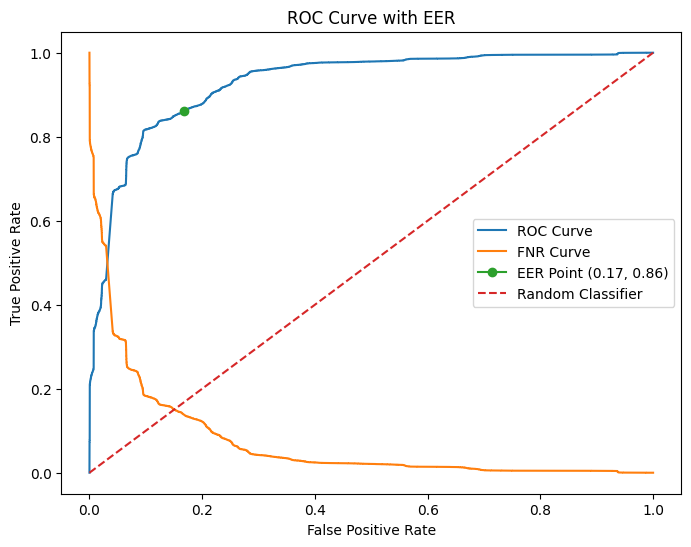

In [28]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot(fpr, fnr, label='FNR Curve')
plt.plot(fpr[eer_index], tpr[eer_index], marker='o', label=f'EER Point ({fpr[eer_index]:.2f}, {tpr[eer_index]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with EER')
plt.legend()
plt.show()


In [ ]:
# Load pre-trained ResNet-50 model (without top layer)
base_model = tf.keras.applications.ResNet101(  
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model.trainable = False

# Add custom classification layers
model_resnet101 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model_resnet101.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model_resnet101.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
   2/2081 ━━━━━━━━━━━━━━━━━━━━ 2:37:34 5s/step - accuracy: 0.7031 - loss: 0.6773  

In [ ]:

# Evaluate model on test set

test_loss, test_acc = model_resnet101.evaluate(test_generator)

print(f'Test Accuracy: {test_acc:.4f}')


In [ ]:
import time
# Get true labels
y_true = test_generator.classes
start_time = time.time()
# Get model predictions (probabilities)
y_pred_resnet101 = model_resnet101.predict(test_generator).ravel()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"running time : {elapsed_time : .4f} s")
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_resnet101)
roc_auc = auc(fpr, tpr)

# Compute EER
fnr = 1 - tpr
eer_threshold = brentq(lambda x: 1. - x - interp1d(fpr, fnr)(x), 0., 1.)
eer = fpr[np.nanargmin(np.abs(fpr - fnr))]
print(f'EER: {eer:.4f}')


In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot(fpr, fnr, label='FNR Curve')
plt.plot(fpr[eer_index], tpr[eer_index], marker='o', label=f'EER Point ({fpr[eer_index]:.2f}, {tpr[eer_index]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with EER')
plt.legend()
plt.show()


In [ ]:
#optimized model

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

# 加载预训练模型（不包含分类头）
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# 冻结大部分层（只训练最后几层）
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)  # 代替 Flatten
x = Dense(512, activation="relu")(x)  # 增加神经元数
x = BatchNormalization()(x)  # 加 BN
x = Dropout(0.2)(x)  # Dropout 降低到 0.2，防止过拟合
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

model_mobilenetv3 = Model(inputs=base_model.input, outputs=output)
model_mobilenetv3.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 回调函数：提前停止 & 动态调整学习率
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

# 训练模型
history = model_mobilenetv3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt
import time 
# Assume y_true and y_pred_prob are your true labels and predicted probabilities
y_true = test_generator.classes  # True labels
start_time = time.time()
y_pred_mobilenetv3 = model_mobilenetv3.predict(test_generator)  # Predicted probabilities
end_time = time.time()
elapsed_time = end_time - start_time
print(f"running time : {elapsed_time: .4f} s )
# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_mobilenetv3)

# Calculate FNR (False Negative Rate)
fnr = 1 - tpr

# Find the optimal threshold where FPR equals FNR (EER)
eer_index = np.nanargmin(np.abs(fnr - fpr))
optimal_threshold = thresholds[eer_index]
eer = fpr[eer_index]

print(f"Optimal Threshold: {optimal_threshold}")
print(f"EER: {eer * 100:.2f}%")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot(fpr, fnr, label='FNR Curve')
plt.plot(fpr[eer_index], tpr[eer_index], marker='o', label=f'EER Point ({fpr[eer_index]:.2f}, {tpr[eer_index]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with EER')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.applications import EfficientNetV2B1
base_model = EfficientNetV2B1(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
# Freeze base model
base_model.trainable = False

# Add custom classification layers
model_efficientnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model_efficientnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model_efficientnet.fit(train_generator, epochs=10, validation_data=val_generator)

In [ ]:
# Assume y_true and y_pred_prob are your true labels and predicted probabilities
y_true = test_generator.classes  # True labels
y_pred_efficientnet = model_efficientnet.predict(test_generator)  # Predicted probabilities

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_efficientnet)

# Calculate FNR (False Negative Rate)
fnr = 1 - tpr

# Find the optimal threshold where FPR equals FNR (EER)
eer_index = np.nanargmin(np.abs(fnr - fpr))
optimal_threshold = thresholds[eer_index]
eer = fpr[eer_index]

print(f"Optimal Threshold: {optimal_threshold}")
print(f"EER: {eer * 100:.2f}%")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot(fpr, fnr, label='FNR Curve')
plt.plot(fpr[eer_index], tpr[eer_index], marker='o', label=f'EER Point ({fpr[eer_index]:.2f}, {tpr[eer_index]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with EER')
plt.legend()
plt.show()

### Mobilenet v3 pro 

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import backend as K
from sklearn.metrics import roc_curve, auc
import numpy as np

In [3]:
# **Focal Loss**
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)  # 避免 log(0) 错误
        pos_loss = -alpha * (y_true * K.pow(1 - y_pred, gamma) * K.log(y_pred))
        neg_loss = - (1 - alpha) * ((1 - y_true) * K.pow(y_pred, gamma) * K.log(1 - y_pred))
        return K.mean(pos_loss + neg_loss)
    return loss

# **AUC Maximization Loss**
def auc_loss():
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        return -tf.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    return loss

# **模型架构**
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# 冻结大部分层（只训练最后几层）
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

model_mobilenetv3pro = Model(inputs=base_model.input, outputs=output)

# **选择损失函数（你可以选择 Focal Loss 或 AUC Loss）**
# model.compile(optimizer="adam", loss=focal_loss(), metrics=["accuracy"])
model_mobilenetv3pro.compile(optimizer="adam", loss=auc_loss(), metrics=["accuracy"])

In [4]:
# **训练模型**
model_mobilenetv3pro.fit(train_generator, epochs=5, validation_data=val_generator, steps_per_epoch=len(train_generator), validation_steps=len(val_generator))

C:\Users\s221430749\AppData\Local\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 4450s 2s/step - accuracy: 0.9023 - loss: 0.2364 - val_accuracy: 0.5998 - val_loss: 0.6842
Epoch 2/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 4491s 2s/step - accuracy: 0.9768 - loss: 0.0657 - val_accuracy: 0.7545 - val_loss: 0.8697
Epoch 3/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 4899s 2s/step - accuracy: 0.9868 - loss: 0.0390 - val_accuracy: 0.8621 - val_loss: 0.8900
Epoch 4/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 3990s 2s/step - accuracy: 0.9904 - loss: 0.0289 - val_accuracy: 0.8566 - val_loss: 0.6782
Epoch 5/5
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 4905s 2s/step - accuracy: 0.9916 - loss: 0.0248 - val_accuracy: 0.8326 - val_loss: 0.7361


1235/1235 ━━━━━━━━━━━━━━━━━━━━ 931s 747ms/step 
模型运行时间: 936.3877 秒
Optimal Threshold: 0.024828488007187843
EER: 4.93%


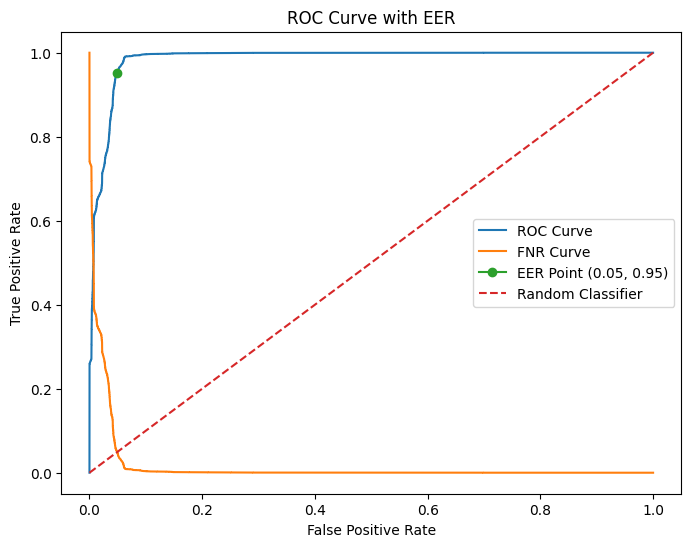

In [5]:
import matplotlib.pyplot as plt
import time
# Assume y_true and y_pred_prob are your true labels and predicted probabilities
y_true = test_generator.classes  # True labels
start_time = time.time()  # 记录开始时间
y_pred_mobilenetv3pro = model_mobilenetv3pro.predict(test_generator)  # Predicted probabilities
end_time = time.time()  # 记录结束时间
elapsed_time = end_time - start_time  # 计算运行时间
print(f"模型运行时间: {elapsed_time:.4f} 秒")
# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_mobilenetv3pro)

# Calculate FNR (False Negative Rate)
fnr = 1 - tpr

# Find the optimal threshold where FPR equals FNR (EER)
eer_index = np.nanargmin(np.abs(fnr - fpr))
optimal_threshold = thresholds[eer_index]
eer = fpr[eer_index]

print(f"Optimal Threshold: {optimal_threshold}")
print(f"EER: {eer * 100:.2f}%")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot(fpr, fnr, label='FNR Curve')
plt.plot(fpr[eer_index], tpr[eer_index], marker='o', label=f'EER Point ({fpr[eer_index]:.2f}, {tpr[eer_index]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with EER')
plt.legend()
plt.show()

Plot all roc results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



# 存储所有模型的结果
models = {
    "ResNet50": y_pred_resnet50,
    "ResNet101": y_pred_resnet101,
    "MobileNet": y_pred_mobilenet,
    "EfficientNet": y_pred_efficientnet,
    "Mobilenet v3": y_pred_mobilenetv3,
    "Mobilenet v3 pro": y_pred_mobilenetv3pro
}

plt.figure(figsize=(8, 6))

# 计算并绘制每个模型的 ROC 和 EER
for model_name, y_scores in models.items():
    # 计算 ROC 曲线
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # 计算 EER（找到 FPR ≈ 1 - TPR 的点）
    eer_index = np.nanargmin(np.abs(fpr - (1 - tpr)))  # 误差最小的索引
    eer = fpr[eer_index]  # EER 值
    eer_threshold = thresholds[eer_index]  # 对应的阈值
    
    # 绘制 ROC 曲线
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f}, EER = {eer:.3f})")
    
    # 标注 EER 点
    plt.scatter(fpr[eer_index], tpr[eer_index], marker='o', color='black', label=f"{model_name} EER")

# 绘制参考线
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 参考线（随机猜测）
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Comparison with EER")
plt.legend()
plt.grid()
plt.show()

Mobilenet v3 + Arcface

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# 自定义 ArcFace 损失层
class ArcFaceLoss(layers.Layer):
    def __init__(self, num_classes, margin=0.5, scale=64, **kwargs):
        super(ArcFaceLoss, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale
        self.w = self.add_weight(name="w", shape=(512, num_classes),
                                 initializer="glorot_uniform", trainable=True)

    def call(self, embeddings, labels):
        norm_embeddings = tf.nn.l2_normalize(embeddings, axis=1)
        norm_w = tf.nn.l2_normalize(self.w, axis=0)
        logits = tf.matmul(norm_embeddings, norm_w)
        theta = tf.acos(tf.clip_by_value(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        theta = theta + tf.one_hot(labels, self.num_classes) * self.margin
        return self.scale * tf.cos(theta)

# **修正：构建 MobileNetV3 + ArcFace 模型**
def build_mobilenetv3_arcface(num_classes):
    base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224, 3), 
                                                        include_top=False, pooling='avg')

    # 512 维度特征层
    x = layers.Dense(512, activation=None, name="embedding")(base_model.output)
    x = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(x)

    # **创建 labels 作为模型输入**
    labels_input = layers.Input(shape=(), dtype=tf.int32, name="arcface_labels")  

    # **将 labels 传递给 ArcFaceLoss**
    output = ArcFaceLoss(num_classes)(x, labels_input)

    # **修正模型 inputs，避免重复定义 labels**
    model = Model(inputs=[base_model.input, labels_input], outputs=output)
    return model

# **创建模型**
num_classes = 10  
model = build_mobilenetv3_arcface(num_classes)

# **编译模型**
model.compile(optimizer="adam", 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["accuracy"])




In [8]:
import tensorflow as tf

def arcface_data_generator(generator):
    """将 train_generator 适配成 TensorFlow Dataset"""
    def generator_wrapper():
        for images, labels in generator:
            # ✅ 确保是 Tensor
            images = tf.convert_to_tensor(images, dtype=tf.float32)
            labels = tf.convert_to_tensor(labels, dtype=tf.int32)
            yield (images, labels), labels  # ✅ 这里返回 tuple，而不是 list

    # ✅ 修正 output_signature（确保结构匹配）
    output_signature = (
        (tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # 图像
         tf.TensorSpec(shape=(None,), dtype=tf.int32)),               # 类别标签
        tf.TensorSpec(shape=(None,), dtype=tf.int32)                  # 真实标签
    )

    return tf.data.Dataset.from_generator(generator_wrapper, output_signature=output_signature)

# ✅ 训练数据
train_dataset = arcface_data_generator(train_generator)
val_dataset = arcface_data_generator(val_generator)

# ✅ 训练模型
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


Epoch 1/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 3521s 2s/step - accuracy: 0.9452 - loss: 1.6931 - val_accuracy: 0.5154 - val_loss: 30.9838
Epoch 2/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 3814s 2s/step - accuracy: 0.9969 - loss: 0.0670 - val_accuracy: 0.2370 - val_loss: 25.6147
Epoch 3/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 3799s 2s/step - accuracy: 0.9976 - loss: 0.0496 - val_accuracy: 0.5153 - val_loss: 29.0050
Epoch 4/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 3850s 2s/step - accuracy: 0.9979 - loss: 0.0416 - val_accuracy: 0.6646 - val_loss: 18.0225
Epoch 5/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 3807s 2s/step - accuracy: 0.9984 - loss: 0.0343 - val_accuracy: 0.5153 - val_loss: 31.1430
Epoch 6/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 3919s 2s/step - accuracy: 0.9983 - loss: 0.0359 - val_accuracy: 0.5153 - val_loss: 32.2805
Epoch 7/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 3901s 2s/step - accuracy: 0.9991 - loss: 0.0213 - val_accuracy: 0.5153 - val_loss: 30.6901
Epoch 8/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 3894s 2s/step - accuracy: 0

In [17]:
for batch in test_generator:
    print(f"Type of batch: {type(batch)}")
    print(f"Length of batch: {len(batch)}")
    print(f"Batch content: {batch}")
    break  # Only print the first batch to avoid too much output


Type of batch: <class 'tuple'>
Length of batch: 2
Batch content: (array([[[[0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         ...,
         [0.04313726, 0.04313726, 0.04313726],
         [0.04313726, 0.04313726, 0.04313726],
         [0.04313726, 0.04313726, 0.04313726]],

        [[0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         ...,
         [0.04313726, 0.04313726, 0.04313726],
         [0.04313726, 0.04313726, 0.04313726],
         [0.04313726, 0.04313726, 0.04313726]],

        [[0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         ...,
         [0.03921569, 0.03921569, 0.03921569],
         [0.03921569, 0.03921569, 0.03921569],
         [0.03921569, 0.03921569, 0.03921569]],

        ...,

        [[0.04313726, 0.04

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def evaluate_model(model, test_generator):
    """计算 EER 并绘制 ROC 曲线"""
    y_true = []
    y_scores = []

    for batch in test_generator:
        # ✅ Correct unpacking
        if isinstance(batch, tuple) and len(batch) == 2:
            images, labels = batch  # ✅ Use correct format
        else:
            raise ValueError(f"Unexpected batch format: {batch}")

        # ✅ Pass both inputs to ArcFace model
        try:
            preds = model.predict([images, labels])  # ✅ Fix: Pass both image & label
        except Exception as e:
            raise ValueError(f"Error in model prediction: {e}")

        # ✅ Convert logits to probabilities if needed
        if preds.shape[-1] > 1:
            preds = tf.nn.softmax(preds, axis=-1).numpy()

        # ✅ Extract relevant score (for binary/multi-class cases)
        preds = preds[:, 1] if preds.shape[-1] == 2 else np.max(preds, axis=-1)

        # ✅ Ensure labels are NumPy arrays
        labels = np.array(labels)  # Avoid `.numpy()` issues

        y_true.extend(labels)
        y_scores.extend(preds)

    # ✅ Convert lists to NumPy arrays
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # ✅ Compute FPR, TPR, EER
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    eer_index = np.nanargmin(np.abs(fpr - (1 - tpr)))
    eer_threshold = thresholds[eer_index]
    eer = fpr[eer_index]

    # ✅ Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc(fpr, tpr):.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.scatter(eer, 1 - eer, color='red', label=f'EER = {eer:.4f}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve & EER")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"EER: {eer:.4f} at threshold: {eer_threshold:.4f}")

# 调用方法
evaluate_model(model, test_generator)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from scipy import interpolate

# 设置GPU内存动态增长
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
# **Focal Loss**
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)  # 避免 log(0) 错误
        pos_loss = -alpha * (y_true * K.pow(1 - y_pred, gamma) * K.log(y_pred))
        neg_loss = - (1 - alpha) * ((1 - y_true) * K.pow(y_pred, gamma) * K.log(1 - y_pred))
        return K.mean(pos_loss + neg_loss)
    return loss

# **AUC Maximization Loss**
def auc_loss():
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        return -tf.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    return loss
base_model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3),
                                               alpha=1.0,
                                               depth_multiplier=1,
                                               dropout=0.001,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model_mobilenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # 输出一个概率值
])

model_mobilenet.compile(optimizer='adam',
              loss=auc_loss(),
              metrics=['accuracy'])


Epoch 1/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 4946s 2s/step - accuracy: 0.9746 - loss: 0.0644 - val_accuracy: 0.8851 - val_loss: 0.8511
Epoch 2/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 4754s 2s/step - accuracy: 0.9958 - loss: 0.0145 - val_accuracy: 0.9227 - val_loss: 0.6454
Epoch 3/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 4772s 2s/step - accuracy: 0.9959 - loss: 0.0155 - val_accuracy: 0.9253 - val_loss: 0.5780
Epoch 4/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 4760s 2s/step - accuracy: 0.9978 - loss: 0.0104 - val_accuracy: 0.9191 - val_loss: 0.8033
Epoch 5/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 4945s 2s/step - accuracy: 0.9984 - loss: 0.0082 - val_accuracy: 0.9098 - val_loss: 1.0134
Epoch 6/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 4855s 2s/step - accuracy: 0.9976 - loss: 0.0148 - val_accuracy: 0.9457 - val_loss: 0.6923
Epoch 7/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 4762s 2s/step - accuracy: 0.9979 - loss: 0.0160 - val_accuracy: 0.9323 - val_loss: 0.8372
Epoch 8/10
2081/2081 ━━━━━━━━━━━━━━━━━━━━ 4777s 2s/step - accuracy: 0.9988 -

IndexError: index 3285 is out of bounds for axis 0 with size 837

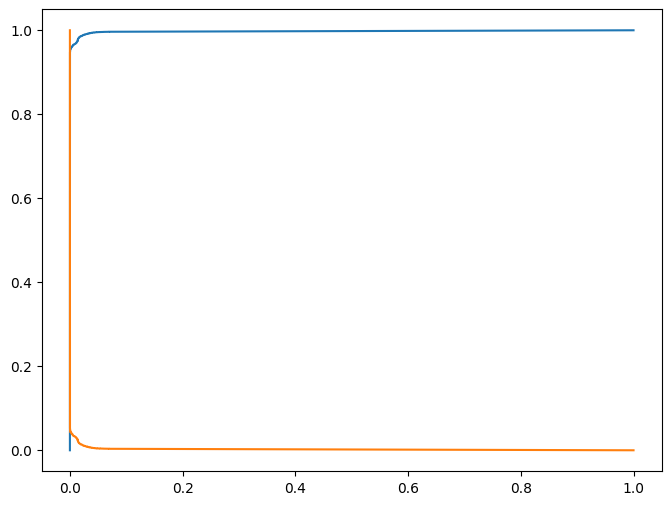

In [8]:
import time
# 训练模型
history = model_mobilenet.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# 测试模型

test_loss, test_acc = model_mobilenet.evaluate(test_generator)

print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

# 获取预测结果
y_true = test_generator.classes
start_time = time.time()  # 记录开始时间
y_pred_mobilenet = model_mobilenet.predict(test_generator)
end_time = time.time()  # 记录结束时间
elapsed_time = end_time - start_time  # 计算运行时间
print(f"模型运行时间: {elapsed_time:.4f} 秒")
y_pred_mobilenet = y_pred_mobilenet.ravel()

# 计算 ROC 和 AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_mobilenet)
roc_auc = auc(fpr, tpr)

# 计算 EER (Equal Error Rate)
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fpr - (1 - tpr)))
eer_threshold = interpolate.interp1d(fpr, fnr)(0.05)  # 找到FPR和FNR相等的阈值
print(f'EER: {eer_threshold}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot(fpr, fnr, label='FNR Curve')
plt.plot(fpr[eer_index], tpr[eer_index], marker='o', label=f'EER Point ({fpr[eer_index]:.2f}, {tpr[eer_index]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with EER')
plt.legend()
plt.show()



### 622 data format

In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define dataset paths
dataset_root = "C:\\Users\\s221430749\\Downloads\\VRBiom\\VRBiom\\data"  # Root directory containing subfolders with .avi files
output_path = "C:\\Users\\s221430749\\Downloads\\VRBiom\\622"  # Where extracted frames will be stored

# Create output folders
os.makedirs(output_path, exist_ok=True)

# Step 1: Recursively find all .avi files in subdirectories
video_files = []
for root, _, files in os.walk(dataset_root):
    for file in files:
        if file.endswith(".avi"):
            video_files.append(os.path.join(root, file))

# Step 2: Extract unique identities (Assume identity is in folder name or filename)
identities = list(set([os.path.basename(os.path.dirname(v)) for v in video_files]))  # Parent folder as identity

# Step 3: Split identities into train (60%), val (20%), test (20%) ensuring disjoint sets
train_ids, temp_ids = train_test_split(identities, test_size=0.4, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# Step 4: Process videos and extract frames
for video_path in video_files:
    identity = os.path.basename(os.path.dirname(video_path))  # Identity from parent folder
    partition = "train" if identity in train_ids else "val" if identity in val_ids else "test"

    # Open video file
    cap = cv2.VideoCapture(video_path)
    
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Save every 10th frame
        if frame_idx % 10 == 0:
            save_folder = os.path.join(output_path, partition, identity)
            os.makedirs(save_folder, exist_ok=True)
            frame_filename = os.path.join(save_folder, f"{os.path.basename(video_path)}_frame{frame_idx}.jpg")
            cv2.imwrite(frame_filename, frame)

        frame_idx += 1
    
    cap.release()

print("Dataset processing complete! Frames are stored in:")
print(f"{output_path}/train, {output_path}/val, {output_path}/test")



Dataset processing complete! Frames are stored in:
C:\Users\s221430749\Downloads\VRBiom\622/train, C:\Users\s221430749\Downloads\VRBiom\622/val, C:\Users\s221430749\Downloads\VRBiom\622/test


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 定义图像尺寸和批次大小
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 数据增强
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# 加载数据
train_generator = train_datagen.flow_from_directory(
    "C:\\Users\\s221430749\\Downloads\\VRBiom\\622\\train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)
import numpy as np
import os

# Function to extract class name from filename
def get_class_from_filename(filename):
    # Check if 'BF' is present in the filename
    if 'BF' in filename:
        return 'BF'
    return 'Other'  # For any filenames that don't contain 'BF'

# Apply function to each filename
class_labels = [get_class_from_filename(f) for f in train_generator.filenames]

# Convert labels to binary: 1 if 'BF' is found, otherwise 0
train_labels = np.array([1 if label == 'BF' else 0 for label in class_labels])

# Update the labels in the generator
train_generator.classes = train_labels


val_generator = val_test_datagen.flow_from_directory(
    "C:\\Users\\s221430749\\Downloads\\VRBiom\\622\\val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)


test_generator = val_test_datagen.flow_from_directory(
    "C:\\Users\\s221430749\\Downloads\\VRBiom\\622\\test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)
# Apply function to each filename
class_labels_val = [get_class_from_filename(f) for f in val_generator.filenames]

# Convert labels to binary: 1 if 'BF' is found, otherwise 0
val_labels = np.array([1 if label == 'BF' else 0 for label in class_labels_val])

# Update the labels in the generator
val_generator.classes = val_labels

# Apply function to each filename
class_labels_test = [get_class_from_filename(f) for f in test_generator.filenames]

# Convert labels to binary: 1 if 'BF' is found, otherwise 0
test_labels = np.array([1 if label == 'BF' else 0 for label in class_labels_test])

# Update the labels in the generator
test_generator.classes = test_labels


Found 85738 images belonging to 70 classes.
Found 26626 images belonging to 23 classes.
Found 30588 images belonging to 24 classes.


### 622 data results

### Resnet 50 

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# **加载 ResNet-50 预训练模型（去掉顶部分类层）**
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# 冻结预训练模型的层
base_model.trainable = False

# **构建分类模型**
model_resnet50 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # 二分类
])

# **编译模型**
model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# **训练模型**
history = model_resnet50.fit(train_generator, epochs=5, validation_data=val_generator)

# **评估模型**
test_loss, test_acc = model_resnet50.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

# **获取真实标签**
y_true = test_generator.classes

# **计算推理时间**
start_time = time.time()
y_pred_prob = model_resnet50.predict(test_generator).ravel()  # 预测概率
end_time = time.time()
elapsed_time = end_time - start_time
avg_inference_time = (elapsed_time / len(test_generator)) * 1000  # 每张图像推理时间（ms）

# **计算 ROC 曲线**
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# **计算 EER**
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fpr - fnr))
optimal_threshold = thresholds[eer_index]
eer = fpr[eer_index]

# **计算 Precision, Recall, F1-Score**
y_pred_binary = (y_pred_prob >= optimal_threshold).astype(int)  # 应用最优阈值
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# **计算模型大小**
model_size = model_resnet50.count_params() * 4 / (1024 ** 2)  # MB（假设每个参数占 4 字节）

# **打印评估结果**
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"EER: {eer * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
print(f"Model Size: {model_size:.2f} MB")
print(f"Avg Inference Time: {avg_inference_time:.2f} ms per image")

# **绘制 ROC 曲线**
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(roc_auc))
plt.plot(fpr, fnr, label='FNR Curve')
plt.plot(fpr[eer_index], tpr[eer_index], marker='o', markersize=8, label=f'EER Point ({eer * 100:.2f}%)')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet-50 ROC Curve with EER')
plt.legend()
plt.show()


C:\Users\s221430749\AppData\Local\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 12413s 5s/step - accuracy: 0.5878 - loss: 0.6645 - val_accuracy: 0.8074 - val_loss: 0.4516
Epoch 2/5
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 11234s 4s/step - accuracy: 0.6909 - loss: 0.5575 - val_accuracy: 0.8518 - val_loss: 0.3893
Epoch 3/5
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 11048s 4s/step - accuracy: 0.7052 - loss: 0.5328 - val_accuracy: 0.7896 - val_loss: 0.3872
Epoch 4/5
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 11230s 4s/step - accuracy: 0.7115 - loss: 0.5229 - val_accuracy: 0.8584 - val_loss: 0.4029
Epoch 5/5
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 11298s 4s/step - accuracy: 0.7173 - loss: 0.5144 - val_accuracy: 0.8495 - val_loss: 0.4105
956/956 ━━━━━━━━━━━━━━━━━━━━ 3074s 3s/step - accuracy: 0.9050 - loss: 0.3995
Test Accuracy: 0.8415
956/956 ━━━━━━━━━━━━━━━━━━━━ 3011s 3s/step


TypeError: 'float' object is not callable

956/956 ━━━━━━━━━━━━━━━━━━━━ 2791s 3s/step
model running time: 2793.1575 s
EER: 0.1695


NameError: name 'eer_index' is not defined

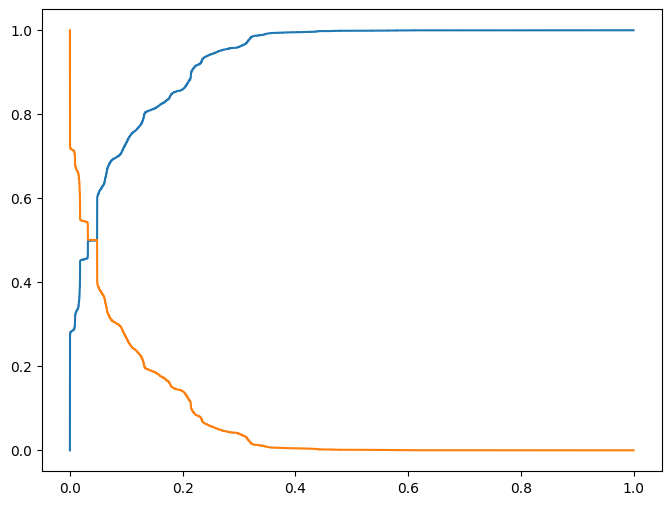

### Resnet 101

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# **加载 ResNet-101 预训练模型（去掉顶部分类层）**
base_model = ResNet101(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# **冻结预训练模型的层**
base_model.trainable = False

# **构建分类模型**
model_resnet101 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # 二分类
])

# **编译模型**
model_resnet101.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# **训练模型**
history = model_resnet101.fit(train_generator, epochs=5, validation_data=val_generator)

# **评估模型**
test_loss, test_acc = model_resnet101.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

# **获取真实标签**
y_true = test_generator.classes

# **计算推理时间**
start_time = time.time()
y_pred_prob = model_resnet101.predict(test_generator).ravel()  # 预测概率
end_time = time.time()
total_inference_time = end_time - start_time
avg_inference_time = (total_inference_time / len(test_generator)) * 1000  # ms

# **计算 ROC 曲线**
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# **计算 EER**
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fpr - fnr))
optimal_threshold = thresholds[eer_index]
eer = fpr[eer_index]

# **计算 Precision, Recall, F1-Score**
y_pred_binary = (y_pred_prob >= optimal_threshold).astype(int)  # 应用最优阈值
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# **计算模型大小**
model_size = model_resnet101.count_params() * 4 / (1024 ** 2)  # MB（假设每个参数占 4 字节）

# **打印评估结果**
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"EER: {eer * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
print(f"Model Size: {model_size:.2f} MB")
print(f"Avg Inference Time: {avg_inference_time:.2f} ms per image")

# **绘制 ROC 曲线**
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(roc_auc))
plt.plot(fpr, fnr, label='FNR Curve')
plt.plot(fpr[eer_index], tpr[eer_index], marker='o', markersize=8, label=f'EER Point ({eer * 100:.2f}%)')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet-101 ROC Curve with EER')
plt.legend()
plt.show()


Epoch 1/5
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 20822s 8s/step - accuracy: 0.6188 - loss: 0.6315 - val_accuracy: 0.8257 - val_loss: 0.4422
Epoch 2/5
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 21085s 8s/step - accuracy: 0.7125 - loss: 0.5248 - val_accuracy: 0.8446 - val_loss: 0.4238
Epoch 3/5
 466/2680 ━━━━━━━━━━━━━━━━━━━━ 3:43:36 6s/step - accuracy: 0.7340 - loss: 0.4982

KeyboardInterrupt: 

### Mobilenet v3 pro 

C:\Users\s221430749\AppData\Local\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 4354s 2s/step - accuracy: 0.8967 - loss: 0.2501 - val_accuracy: 0.6162 - val_loss: 5.9480
Epoch 2/4
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 5352s 2s/step - accuracy: 0.9740 - loss: 0.0712 - val_accuracy: 0.7249 - val_loss: 1.2097
Epoch 3/4
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 3129s 1s/step - accuracy: 0.9852 - loss: 0.0417 - val_accuracy: 0.9177 - val_loss: 0.4090
Epoch 4/4
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 3155s 1s/step - accuracy: 0.9913 - loss: 0.0265 - val_accuracy: 0.7194 - val_loss: 1.9641
956/956 ━━━━━━━━━━━━━━━━━━━━ 512s 533ms/step
Optimal Threshold: 1.0000
EER: 6.02%
Precision: 93.79%
Recall: 93.98%
F1-Score: 93.88%
Model Size: 13.82 MB
Avg Inference Time: 536.51 ms per image


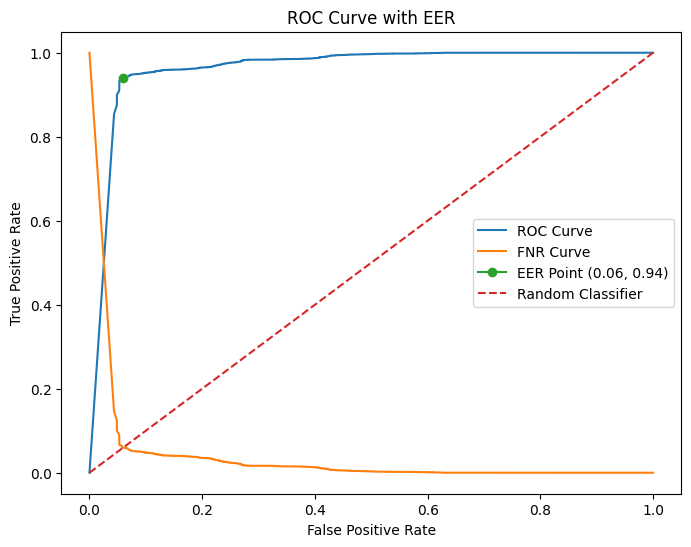

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import backend as K
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
import numpy as np
import time
import os

# **Focal Loss**
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)  # 避免 log(0) 错误
        pos_loss = -alpha * (y_true * K.pow(1 - y_pred, gamma) * K.log(y_pred))
        neg_loss = - (1 - alpha) * ((1 - y_true) * K.pow(y_pred, gamma) * K.log(1 - y_pred))
        return K.mean(pos_loss + neg_loss)
    return loss

# **AUC Maximization Loss**
def auc_loss():
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        return -tf.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    return loss

# **模型架构**
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# 冻结大部分层（只训练最后几层）
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

model_mobilenetv3pro = Model(inputs=base_model.input, outputs=output)

# **选择损失函数（你可以选择 Focal Loss 或 AUC Loss）**
# model.compile(optimizer="adam", loss=focal_loss(), metrics=["accuracy"])
model_mobilenetv3pro.compile(optimizer="adam", loss=auc_loss(), metrics=["accuracy"])

# **训练模型**
model_mobilenetv3pro.fit(train_generator, epochs=4, validation_data=val_generator, steps_per_epoch=len(train_generator), validation_steps=len(val_generator))

import matplotlib.pyplot as plt

# **评估模型**
y_true = test_generator.classes  # 真实标签

# **计算模型推理时间**
start_time = time.time()
y_pred_prob = model_mobilenetv3pro.predict(test_generator)  # 预测概率
end_time = time.time()
elapsed_time = end_time - start_time  # 总运行时间
avg_inference_time = (elapsed_time / len(test_generator)) * 1000  # 转换为 ms

# **计算 EER**
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fnr - fpr))
optimal_threshold = thresholds[eer_index]
eer = fpr[eer_index]

# **计算 Precision, Recall, F1-Score**
y_pred_binary = (y_pred_prob >= optimal_threshold).astype(int)  # 使用最优阈值转换为二进制
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# **计算模型大小**
model_size = model_mobilenetv3pro.count_params() * 4 / (1024 ** 2)  # 转换为 MB（假设每个参数占 4 字节）

# **打印结果**
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"EER: {eer * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
print(f"Model Size: {model_size:.2f} MB")
print(f"Avg Inference Time: {avg_inference_time:.2f} ms per image")

# **绘制 ROC 曲线**
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot(fpr, fnr, label='FNR Curve')
plt.plot(fpr[eer_index], tpr[eer_index], marker='o', label=f'EER Point ({fpr[eer_index]:.2f}, {tpr[eer_index]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with EER')
plt.legend()
plt.show()


### PGD attack

In [4]:
print(np.ceil(test_generator.samples/test_generator.batch_size))  # 获取批量大小

956.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step

------ Adversarial Attack Evaluation (PGD - Batch Optimized) ------
EER (Adversarial): Cannot be computed
Precision (Adversarial): 100.00%
Recall (Adversarial): 5.31%
F1-Score (Adversarial): 10.09%
Avg Inference Time (Adversarial): 5.14 ms per image


C:\Users\s221430749\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:1137: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


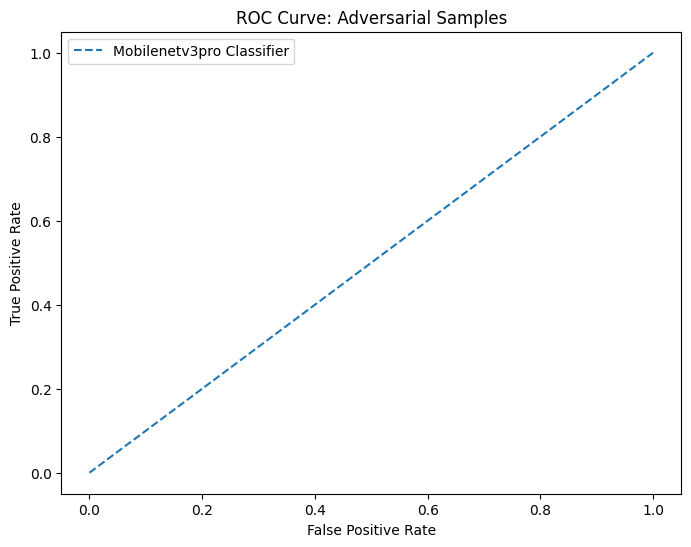

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# **对抗攻击 - Projected Gradient Descent (PGD) 批量版**
# ------------------------------------------------------------
def pgd_attack_batch(images, labels, model, epsilon=0.01, alpha=0.005, iterations=5):
    """对一个 batch 的图像进行 PGD 攻击"""
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    labels = tf.reshape(labels, (-1, 1))  # 保证与 binary_crossentropy 形状匹配

    adv_images = tf.identity(images)

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(adv_images)
            predictions = model(adv_images, training=False)
            loss = tf.keras.losses.binary_crossentropy(labels, predictions)

        gradient = tape.gradient(loss, adv_images)
        perturbation = alpha * tf.sign(gradient)
        adv_images = adv_images + perturbation
        adv_images = tf.clip_by_value(adv_images, images - epsilon, images + epsilon)
        adv_images = tf.clip_by_value(adv_images, 0, 1)

    return adv_images.numpy()

# ------------------------------------------------------------
# **逐批处理 PGD 对抗攻击**
# ------------------------------------------------------------
y_test = test_generator.classes
batch_size = test_generator.batch_size  # 获取批量大小

# 用于存储预测结果
y_pred_adv_list = []
adv_labels_list = []

start_time = time.time()
num_batches_to_process = 10  # 你可以改成 5 或者更小
batch_count = 0
for x_batch, y_batch in test_generator:  # 逐批处理
    if batch_count >= num_batches_to_process:
        break
    adv_batch = pgd_attack_batch(x_batch, y_batch, model_mobilenetv3pro)
    y_pred_adv_batch = model_mobilenetv3pro.predict(adv_batch).ravel()
    
    y_pred_adv_list.append(y_pred_adv_batch)
    adv_labels_list.append(y_batch)
    batch_count +=1

end_time = time.time()
adv_inference_time = (end_time - start_time) / len(y_test) * 1000  # 平均推理时间（毫秒）

# ------------------------------------------------------------
# **评估 PGD 对抗样本性能**
# ------------------------------------------------------------
y_pred_adv = np.concatenate(y_pred_adv_list, axis=0)
adv_labels = np.concatenate(adv_labels_list, axis=0)

# 计算 EER
fpr_adv, tpr_adv, thresholds_adv = roc_curve(adv_labels, y_pred_adv)

if np.isnan(fpr_adv).all() or np.isnan(tpr_adv).all():
    eer_adv = np.nan
else:
    eer_index_adv = np.nanargmin(np.abs(fpr_adv - (1 - tpr_adv)))
    eer_adv = fpr_adv[eer_index_adv]

# Precision, Recall, F1
y_pred_adv_binary = (y_pred_adv >= optimal_threshold).astype(int)
precision_adv = precision_score(adv_labels, y_pred_adv_binary)
recall_adv = recall_score(adv_labels, y_pred_adv_binary)
f1_adv = f1_score(adv_labels, y_pred_adv_binary)

# 打印结果
print("\n------ Adversarial Attack Evaluation (PGD - Batch Optimized) ------")
print(f"EER (Adversarial): {eer_adv * 100:.2f}%" if not np.isnan(eer_adv) else "EER (Adversarial): Cannot be computed")
print(f"Precision (Adversarial): {precision_adv * 100:.2f}%")
print(f"Recall (Adversarial): {recall_adv * 100:.2f}%")
print(f"F1-Score (Adversarial): {f1_adv * 100:.2f}%")
print(f"Avg Inference Time (Adversarial): {adv_inference_time:.2f} ms per image")

# ------------------------------------------------------------
# **绘制 ROC 曲线**
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))
if not np.isnan(fpr_adv).all() and not np.isnan(tpr_adv).all():
    plt.plot(fpr_adv, tpr_adv, label='Adversarial ROC (AUC = {:.4f})'.format(auc(fpr_adv, tpr_adv)), linestyle='dashed')
plt.plot([0, 1], [0, 1], linestyle='--', label="Mobilenetv3pro Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Adversarial Samples')
plt.legend()
plt.show()


In [9]:
print("PGD对抗样本预测结果统计:")
print("Min:", np.min(y_pred_adv))
print("Max:", np.max(y_pred_adv))
print("Mean:", np.mean(y_pred_adv))
print("Std:", np.std(y_pred_adv))


PGD对抗样本预测结果统计:
Min: 0.0018569009
Max: 1.0
Mean: 0.9384371
Std: 0.17522208


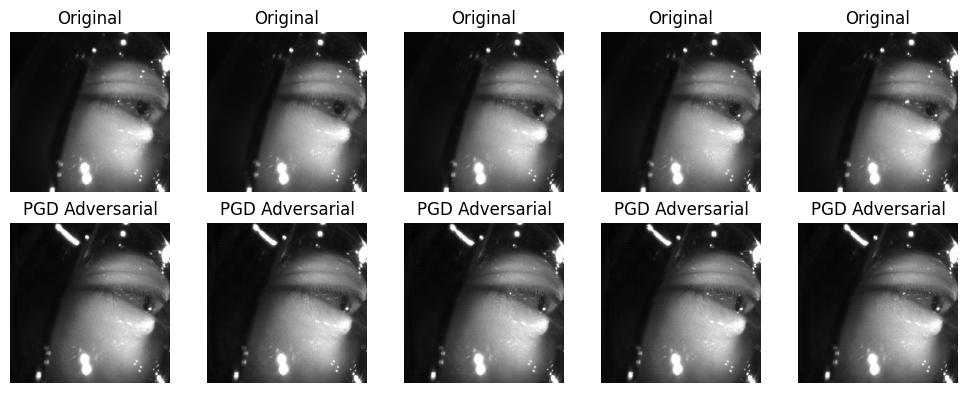

In [10]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_batch[i])
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(adv_batch[i])
    plt.title("PGD Adversarial")
    plt.axis('off')
plt.tight_layout()
plt.show()


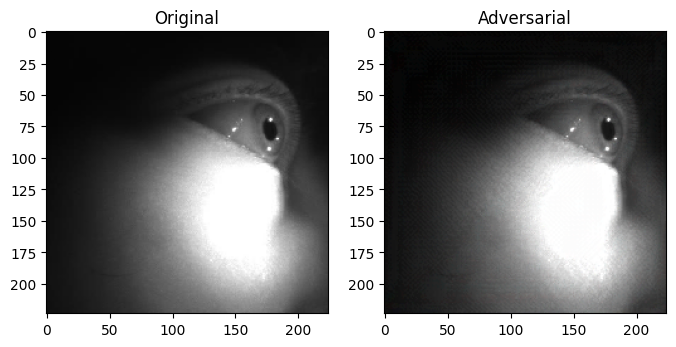

In [34]:
import matplotlib.pyplot as plt

# 显示原始 vs. 对抗样本
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(x_test[0])  # 原始图像
axes[0].set_title("Original")
axes[1].imshow(adv_images[0])  # 对抗样本
axes[1].set_title("Adversarial")
plt.show()


In [49]:
print("Class distribution in test_generator:", np.unique(test_generator.classes, return_counts=True))



Class distribution in test_generator: (array([0, 1]), array([15554, 15034]))


### Mobilenet v3

Epoch 1/5
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 4418s 2s/step - accuracy: 0.6706 - loss: 0.7330 - val_accuracy: 0.3839 - val_loss: 68.8602 - learning_rate: 0.0010
Epoch 2/5
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 4868s 2s/step - accuracy: 0.8951 - loss: 0.2472 - val_accuracy: 0.3835 - val_loss: 104.4380 - learning_rate: 0.0010
Epoch 3/5
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 3992s 1s/step - accuracy: 0.9458 - loss: 0.1411 - val_accuracy: 0.4257 - val_loss: 37.7234 - learning_rate: 0.0010
Epoch 4/5
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 5329s 2s/step - accuracy: 0.9604 - loss: 0.1018 - val_accuracy: 0.4837 - val_loss: 23.5212 - learning_rate: 0.0010
Epoch 5/5
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 4938s 2s/step - accuracy: 0.9675 - loss: 0.0899 - val_accuracy: 0.3921 - val_loss: 265.8446 - learning_rate: 0.0010
956/956 ━━━━━━━━━━━━━━━━━━━━ 590s 614ms/step
Optimal Threshold: 1.0000
EER: 52.73%
Precision: 64.58%
Recall: 99.45%
F1-Score: 78.31%
Model Size: 57.49 MB
Avg Inference Time: 618.45 ms per image


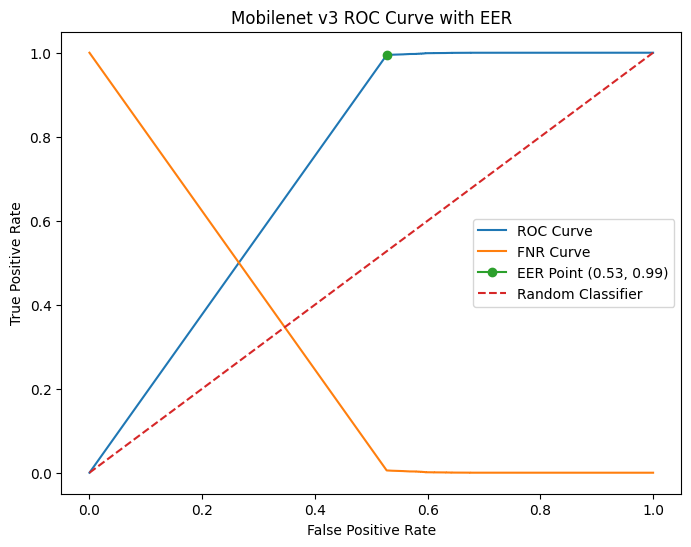

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score
import numpy as np
import time
import matplotlib.pyplot as plt

# **加载预训练模型（不包含分类头）**
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# 冻结大部分层（只训练最后 10 层）
for layer in base_model.layers[:-10]:
    layer.trainable = False

# **构建分类头**
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)  # 二分类问题

# **组合模型**
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# **回调函数**
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

# **训练模型**
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stopping, reduce_lr]
)

# **评估模型**
y_true = test_generator.classes  # 真实标签

# **计算模型推理时间**
start_time = time.time()
y_pred_prob = model.predict(test_generator)  # 预测概率
end_time = time.time()
elapsed_time = end_time - start_time  # 总运行时间
avg_inference_time = (elapsed_time / len(test_generator)) * 1000  # ms per image

# **计算 EER**
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fnr - fpr))
optimal_threshold = thresholds[eer_index]
eer = fpr[eer_index]

# **计算 Precision, Recall, F1-Score**
y_pred_binary = (y_pred_prob >= optimal_threshold).astype(int)  # 使用最优阈值
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# **计算模型大小**
model_size = model.count_params() * 4 / (1024 ** 2)  # 转换为 MB（假设每个参数占 4 字节）

# **打印结果**
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"EER: {eer * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
print(f"Model Size: {model_size:.2f} MB")
print(f"Avg Inference Time: {avg_inference_time:.2f} ms per image")

# **绘制 ROC 曲线**
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot(fpr, fnr, label='FNR Curve')
plt.plot(fpr[eer_index], tpr[eer_index], marker='o', label=f'EER Point ({fpr[eer_index]:.2f}, {tpr[eer_index]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mobilenet v3 ROC Curve with EER')
plt.legend()
plt.show()


### FGSM attack results

In [24]:
# ------------------------------------------------------------
# **对抗攻击 - Fast Gradient Sign Method (FGSM)**
# ------------------------------------------------------------

import tensorflow as tf
import numpy as np

def fgsm_attack(image, label, model, epsilon=0.01):
    """ 生成对抗样本 (FGSM) """
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    label = tf.convert_to_tensor(label, dtype=tf.float32)
    label = tf.reshape(label, (1,1))  # **确保 label 形状匹配 prediction**

    with tf.GradientTape() as tape:
        tape.watch(image)
        image = tf.expand_dims(image, axis=0)  # **添加 batch 维度**
        prediction = model(image, training=False)
        loss = tf.keras.losses.binary_crossentropy(label, prediction)

    # 计算梯度
    gradient = tape.gradient(loss, image)
    perturbation = epsilon * tf.sign(gradient)
    adversarial_image = image + perturbation
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)  # **保持像素值在 [0,1]**
    
    return adversarial_image.numpy().squeeze(0)  # **移除 batch 维度**


# **生成对抗样本**
adv_images = np.array([fgsm_attack(x, y, model) for x, y in zip(test_generator[0][0], test_generator[0][1])])
#adv_labels = test_generator.classes
adv_labels = test_generator.classes[:len(adv_images)]
# **在对抗样本上重新评估**
start_time = time.time()
y_pred_adv = model.predict(adv_images).ravel()
y_pred_adv = y_pred_adv[:len(adv_labels)]  # 截取匹配长度
end_time = time.time()
adv_inference_time = (end_time - start_time) / len(adv_images) * 1000  # ms

# **计算对抗样本 EER**
fpr_adv, tpr_adv, thresholds_adv = roc_curve(adv_labels, y_pred_adv)
eer_index_adv = np.nanargmin(np.abs(fpr_adv - (1 - tpr_adv)))
eer_adv = fpr_adv[eer_index_adv]

# **计算 Precision, Recall, F1**
y_pred_adv_binary = (y_pred_adv >= optimal_threshold).astype(int)
precision_adv = precision_score(adv_labels, y_pred_adv_binary)
recall_adv = recall_score(adv_labels, y_pred_adv_binary)
f1_adv = f1_score(adv_labels, y_pred_adv_binary)

# **打印对抗攻击评估结果**
print("\n------ Adversarial Attack Evaluation (FGSM) ------")
print(f"EER (Adversarial): {eer_adv * 100:.2f}%")
print(f"Precision (Adversarial): {precision_adv * 100:.2f}%")
print(f"Recall (Adversarial): {recall_adv * 100:.2f}%")
print(f"F1-Score (Adversarial): {f1_adv * 100:.2f}%")
print(f"Avg Inference Time (Adversarial): {adv_inference_time:.2f} ms per image")

# **绘制对抗样本 ROC 曲线**
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Original ROC (AUC = {:.4f})'.format(roc_auc))
plt.plot(fpr_adv, tpr_adv, label='Adversarial ROC (AUC = {:.4f})'.format(auc(fpr_adv, tpr_adv)), linestyle='dashed')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Original vs. Adversarial')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


C:\Users\s221430749\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:1137: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


ValueError: All-NaN slice encountered

### add pgd attack to the model to defend the attack

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import backend as K
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
import numpy as np
import time
import os
import matplotlib.pyplot as plt

# -------------------------------
# ⚔️ PGD 对抗样本生成函数
# -------------------------------
def pgd_attack_batch(images, labels, model, epsilon=0.01, alpha=0.003, iterations=10):
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    labels = tf.reshape(labels, (-1, 1))

    adv_images = tf.identity(images)
    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(adv_images)
            predictions = model(adv_images, training=False)
            loss = tf.keras.losses.binary_crossentropy(labels, predictions)
        gradient = tape.gradient(loss, adv_images)
        perturbation = alpha * tf.sign(gradient)
        adv_images = adv_images + perturbation
        adv_images = tf.clip_by_value(adv_images, images - epsilon, images + epsilon)
        adv_images = tf.clip_by_value(adv_images, 0, 1)
    return adv_images

# -------------------------------
# 📌 自定义损失函数
# -------------------------------
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
        pos_loss = -alpha * (y_true * K.pow(1 - y_pred, gamma) * K.log(y_pred))
        neg_loss = - (1 - alpha) * ((1 - y_true) * K.pow(y_pred, gamma) * K.log(1 - y_pred))
        return K.mean(pos_loss + neg_loss)
    return loss

def auc_loss():
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        return -tf.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    return loss

# -------------------------------
# 🧠 模型构建
# -------------------------------
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)
model_mobilenetv3pro = Model(inputs=base_model.input, outputs=output)

# -------------------------------
# ⚙️ 模型训练 - 对抗训练集（PGD）
# -------------------------------
optimizer = tf.keras.optimizers.Adam()
loss_fn = auc_loss()

epochs = 4
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    for step, (x_batch, y_batch) in enumerate(train_generator):
        x_adv = pgd_attack_batch(x_batch, y_batch, model_mobilenetv3pro, epsilon=0.01)
        x_combined = tf.concat([x_batch, x_adv], axis=0)
        y_combined = tf.concat([y_batch, y_batch], axis=0)

        with tf.GradientTape() as tape:
            predictions = model_mobilenetv3pro(x_combined, training=True)
            loss = loss_fn(y_combined, predictions)
        gradients = tape.gradient(loss, model_mobilenetv3pro.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model_mobilenetv3pro.trainable_variables))

        if step % 10 == 0:
            print(f"Step {step}: Loss = {loss.numpy():.4f}")

# -------------------------------
# 📊 模型评估
# -------------------------------
y_true = test_generator.classes
start_time = time.time()
y_pred_prob = model_mobilenetv3pro.predict(test_generator)
end_time = time.time()
avg_inference_time = (end_time - start_time) / len(test_generator) * 1000

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fnr - fpr))
optimal_threshold = thresholds[eer_index]
eer = fpr[eer_index]

y_pred_binary = (y_pred_prob >= optimal_threshold).astype(int)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
model_size = model_mobilenetv3pro.count_params() * 4 / (1024 ** 2)

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"EER: {eer * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
print(f"Model Size: {model_size:.2f} MB")
print(f"Avg Inference Time: {avg_inference_time:.2f} ms per image")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot(fpr, fnr, label='FNR Curve')
plt.plot(fpr[eer_index], tpr[eer_index], marker='o', label=f'EER Point ({fpr[eer_index]:.2f}, {tpr[eer_index]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with EER')
plt.legend()
plt.show()



Epoch 1/4
Step 0: Loss = 0.9724
Step 10: Loss = 0.8237
Step 20: Loss = 0.8338
Step 30: Loss = 0.8683
Step 40: Loss = 0.7858
Step 50: Loss = 0.8516
Step 60: Loss = 0.7413
Step 70: Loss = 0.7421
Step 80: Loss = 0.7469
Step 90: Loss = 0.7347
Step 100: Loss = 0.7317
Step 110: Loss = 0.7460
Step 120: Loss = 0.7366
Step 130: Loss = 0.7767
Step 140: Loss = 0.7560
Step 150: Loss = 0.7634
Step 160: Loss = 0.6933
Step 170: Loss = 0.7919
Step 180: Loss = 0.7636
Step 190: Loss = 0.7086
Step 200: Loss = 0.7166
Step 210: Loss = 0.7061
Step 220: Loss = 0.7373
Step 230: Loss = 0.7248
Step 240: Loss = 0.6882
Step 250: Loss = 0.7135
Step 260: Loss = 0.7223
Step 270: Loss = 0.7262
Step 280: Loss = 0.7039
Step 290: Loss = 0.7437
Step 300: Loss = 0.7183
Step 310: Loss = 0.6954
Step 320: Loss = 0.7628
Step 330: Loss = 0.7439
Step 340: Loss = 0.7276
Step 350: Loss = 0.7138
Step 360: Loss = 0.7911
Step 370: Loss = 0.7151
Step 380: Loss = 0.7400
Step 390: Loss = 0.7051
Step 400: Loss = 0.7379
Step 410: Loss =

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt

# -----------------------------
# PGD 攻击函数（批量版）
# -----------------------------
def pgd_attack_batch(images, labels, model, epsilon=0.01, alpha=0.003, iterations=10):
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    labels = tf.reshape(labels, (-1, 1))  # binary_crossentropy 需要

    adv_images = tf.identity(images)

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(adv_images)
            predictions = model(adv_images, training=False)
            loss = tf.keras.losses.binary_crossentropy(labels, predictions)
        gradient = tape.gradient(loss, adv_images)
        perturbation = alpha * tf.sign(gradient)
        adv_images = adv_images + perturbation
        adv_images = tf.clip_by_value(adv_images, images - epsilon, images + epsilon)
        adv_images = tf.clip_by_value(adv_images, 0, 1)

    return adv_images.numpy()

# -----------------------------
# 开始攻击与评估
# -----------------------------
y_test = test_generator.classes
batch_size = test_generator.batch_size

y_pred_adv_list = []
adv_labels_list = []

start_time = time.time()
batch_count = 0
max_batches = 500  # 可调节处理的批次数量
for x_batch, y_batch in test_generator:
    if batch_count >= max_batches:
        break
    adv_batch = pgd_attack_batch(x_batch, y_batch, model_mobilenetv3pro)
    y_pred_adv_batch = model_mobilenetv3pro.predict(adv_batch).ravel()
    y_pred_adv_list.append(y_pred_adv_batch)
    adv_labels_list.append(y_batch)
    batch_count += 1

end_time = time.time()
adv_inference_time = (end_time - start_time) / len(y_test) * 1000

y_pred_adv = np.concatenate(y_pred_adv_list, axis=0)
adv_labels = np.concatenate(adv_labels_list, axis=0)

# -----------------------------
# EER、Precision、Recall、F1
# -----------------------------
fpr_adv, tpr_adv, thresholds_adv = roc_curve(adv_labels, y_pred_adv)
fnr_adv = 1 - tpr_adv
if np.isnan(fpr_adv).all() or np.isnan(tpr_adv).all():
    eer_adv = np.nan
    optimal_threshold = 0.5
else:
    eer_index_adv = np.nanargmin(np.abs(fpr_adv - fnr_adv))
    eer_adv = fpr_adv[eer_index_adv]
    optimal_threshold = thresholds_adv[eer_index_adv]

# 二值化预测
y_pred_adv_binary = (y_pred_adv >= optimal_threshold).astype(int)
precision_adv = precision_score(adv_labels, y_pred_adv_binary, zero_division=0)
recall_adv = recall_score(adv_labels, y_pred_adv_binary, zero_division=0)
f1_adv = f1_score(adv_labels, y_pred_adv_binary, zero_division=0)

# -----------------------------
# 打印评估结果
# -----------------------------
print("\n------ PGD Adversarial Attack Evaluation ------")
print(f"EER (Adversarial): {eer_adv * 100:.2f}%" if not np.isnan(eer_adv) else "EER (Adversarial): Cannot be computed")
print(f"Precision (Adversarial): {precision_adv * 100:.2f}%")
print(f"Recall (Adversarial): {recall_adv * 100:.2f}%")
print(f"F1-Score (Adversarial): {f1_adv * 100:.2f}%")
print(f"Avg Inference Time (Adversarial): {adv_inference_time:.2f} ms per image")

# -----------------------------
# ROC 曲线图
# -----------------------------
plt.figure(figsize=(8, 6))
if not np.isnan(fpr_adv).all() and not np.isnan(tpr_adv).all():
    plt.plot(fpr_adv, tpr_adv, label='PGD Adversarial ROC (AUC = {:.4f})'.format(auc(fpr_adv, tpr_adv)), linestyle='dashed')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: PGD Adversarial Attack')
plt.legend()
plt.grid()
plt.show()
